In [1]:
%load_ext autoreload
%autoreload 2

# Comet Import and Setup

In [2]:
#comet imports
from comet_ml import Experiment

In [3]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os 

# Create an experiment with your api key
comet_exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),  # don’t hardcode!!
    project_name="milestone_2",
    workspace="morph-e",
    log_code=True,
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/50331850708a45f7a6a22f8c7b8d2ac3



# Imports

In [4]:
#classic
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tempfile

#project imports
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 

#sk-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

#keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, preprocessing, activations



In [5]:
#misc
pd.set_option('display.max_columns', None)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")

# DATA LOADING

In [6]:
#year selection
train_years = [2015,2016,2017]
valid_years = [2018]
test_years=[2019]

In [7]:
train_dataset = SeasonDataSetTwo(train_years)
valid_dataset = SeasonDataSetTwo(valid_years)
train_df = train_dataset.get_features_2()
valid_df = valid_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [8]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


# Split and shuffle

In [9]:
random.seed(42)

In [10]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)

In [11]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
57230,NaN,NaN,2015020953,Anaheim Ducks,2,54.0,9.0,Wrist Shot,0,NaN,466.0,143.282937,3.601278,0,Hit,-78.0,-40.0,6.0,140.801278,False,23.466880,0.0,0.0
54244,NaN,NaN,2015020904,San Jose Sharks,2,-80.0,-5.0,Deflected,0,NaN,280.0,10.295630,-29.054604,0,Hit,-78.0,-39.0,26.0,34.058773,False,1.309953,0.0,0.0
34414,NaN,NaN,2015020577,Colorado Avalanche,2,55.0,-29.0,Wrist Shot,0,NaN,21.0,44.687806,40.462227,0,Faceoff,0.0,0.0,21.0,62.177166,False,2.960817,0.0,0.0
218950,NaN,NaN,2017020759,Winnipeg Jets,3,-80.0,18.0,Slap Shot,0,NaN,261.0,20.124612,63.434949,0,Missed Shot,-78.0,12.0,9.0,6.324555,False,0.702728,0.0,0.0
205456,NaN,NaN,2017020551,Philadelphia Flyers,1,-47.0,-28.0,Wrist Shot,0,NaN,694.0,50.477718,-33.690068,0,Stoppage,NaN,NaN,0.0,NaN,False,NaN,0.0,NaN


# Preprocessing

In [12]:
features = ['gameSeconds','timeFromLastEvent','shotType', 'shotAngle', 'shotDistance','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [13]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
shotType                  True
shotAngle                 True
shotDistance              True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle        False
dtype: bool

In [14]:
#replace inf with nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
valid_df = train_df[train_df['shotType'].notna()]
test_df = train_df[train_df['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
valid_df = train_df[train_df['shotAngle'].notna()]
test_df = train_df[train_df['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
valid_df = train_df[train_df['shotDistance'].notna()]
test_df = train_df[train_df['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
valid_df = train_df[train_df['speed'].notna()]
test_df = train_df[train_df['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
valid_df = train_df[train_df['changeInShotAngle'].notna()]
test_df = train_df[train_df['changeInShotAngle'].notna()]

train_df = train_df[train_df['distanceFromLastEvent'].notna()]
valid_df = train_df[train_df['distanceFromLastEvent'].notna()]
test_df = train_df[train_df['distanceFromLastEvent'].notna()]

In [16]:
#sanity check
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
shotType                 False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
dtype: bool

In [17]:
X_train = train_df[features]
y_train = train_df[label]

X_valid = valid_df[features]
y_valid = valid_df[label]

X_test = test_df[features]
y_test = test_df[label]

X_train, y_train

(        gameSeconds  timeFromLastEvent    shotType  shotAngle  shotDistance  \
 57230         466.0                6.0  Wrist Shot   3.601278    143.282937   
 54244         280.0               26.0   Deflected -29.054604     10.295630   
 34414          21.0               21.0  Wrist Shot  40.462227     44.687806   
 218950        261.0                9.0   Slap Shot  63.434949     20.124612   
 183094        206.0               15.0  Wrist Shot -37.303948     26.400758   
 ...             ...                ...         ...        ...           ...   
 240678       1082.0                6.0  Wrist Shot  -4.332314    132.378246   
 125275       1091.0                4.0   Snap Shot -28.442929     27.294688   
 133908       1128.0                3.0      Tip-In   2.862405     20.024984   
 2630          524.0               11.0  Wrist Shot  30.465545     39.446166   
 15893         712.0               13.0   Snap Shot   2.489553     23.021729   
 
         distanceFromLastEvent  reboun

### One hot encoding for shot type

In [18]:
X_train['shotType'].unique()

array(['Wrist Shot', 'Deflected', 'Slap Shot', 'Backhand', 'Snap Shot',
       'Tip-In', 'Wrap-around'], dtype=object)

In [19]:
dum_train = pd.get_dummies(X_train['shotType'], prefix='Shot',dtype=int)
dum_valid = pd.get_dummies(X_valid['shotType'], prefix='Shot',dtype=int)
dum_test = pd.get_dummies(X_test['shotType'], prefix='Shot',dtype=int)

In [20]:
X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

In [21]:
#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 dtype: bool,
 gameSeconds              False
 timeFromLastEvent        False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         

In [22]:
X_train = X_train.drop(columns='shotType')
X_valid = X_valid.drop(columns='shotType')
X_test = X_test.drop(columns='shotType')
X_train.head()

,gameSeconds,timeFromLastEvent,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
57230,466.0,6.0,3.601278,143.282937,140.801278,False,23.466880,0.0,0,0,0,0,0,0,1
54244,280.0,26.0,-29.054604,10.295630,34.058773,False,1.309953,0.0,0,1,0,0,0,0,0
34414,21.0,21.0,40.462227,44.687806,62.177166,False,2.960817,0.0,0,0,0,0,0,0,1
218950,261.0,9.0,63.434949,20.124612,6.324555,False,0.702728,0.0,0,0,1,0,0,0,0
183094,206.0,15.0,-37.303948,26.400758,57.245087,False,3.816339,0.0,0,0,0,0,0,0,1


## Change rebound to int

In [23]:
X_train['rebound'] = X_train['rebound'].astype(int)
X_valid['rebound'] = X_valid['rebound'].astype(int)
X_test['rebound'] = X_test['rebound'].astype(int)

## Normalize numerical columns

In [24]:
num = ['gameSeconds','timeFromLastEvent', 'shotAngle', 'shotDistance','distanceFromLastEvent','speed','changeInShotAngle']

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num])

X_train[num] = scaler.transform(X_train[num])
X_valid[num] = scaler.transform(X_valid[num])
X_test[num] = scaler.transform(X_test[num])

In [26]:
X_train.head()

,gameSeconds,timeFromLastEvent,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
57230,-0.367822,-0.647129,0.075150,3.083358,1.708358,0,1.532279,-0.362894,0,0,0,0,0,0,1
54244,-0.902143,0.699802,-0.824860,-0.921996,-0.605859,0,-0.659467,-0.362894,0,1,0,0,0,0,0
34414,-1.646171,0.363069,1.091054,0.113838,0.003758,0,-0.496165,-0.362894,0,0,0,0,0,0,1
218950,-0.956724,-0.445089,1.724192,-0.625964,-1.207148,0,-0.719533,-0.362894,0,0,1,0,0,0,0
183094,-1.114722,-0.041010,-1.052216,-0.436937,-0.103171,0,-0.411537,-0.362894,0,0,0,0,0,0,1


# Imbalnced Data check

Based on the imbalanced data tutorial by tensorflow
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [27]:
y_train.value_counts()

isGoal
0         226058
1          22218
dtype: int64

In [28]:
neg, pos = np.bincount(y_train['isGoal'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 248276
    Positive: 22218 (8.95% of total)



### This means that only ~9% of the data is goals -> unbalanced data 

# Neural Network with KERAS

In [90]:
# convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [91]:
for inputs, targets in train_ds.take(2):
    print ('Data: {}, Target: {}'.format(inputs, targets))
    print()

Data: [-0.36782232 -0.64712882  0.07515029  3.08335781  1.70835849  0.
  1.532279   -0.36289432  0.          0.          0.          0.
  0.          0.          1.        ], Target: [0]

Data: [-0.90214322  0.699802   -0.82486002 -0.92199635 -0.60585927  0.
 -0.65946714 -0.36289432  0.          1.          0.          0.
  0.          0.          0.        ], Target: [0]



In [92]:
print(train_ds.cardinality().numpy())

248276


In [93]:
print(val_ds.cardinality().numpy())

248276


In [94]:
BATCH_SIZE = 512

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

for inputs, targets in train_ds.take(3):
    print('Data: ', inputs.numpy()[:3])
    print('Target: ', targets.numpy()[:3])
    print()

Data:  [[-0.36782232 -0.64712882  0.07515029  3.08335781  1.70835849  0.
   1.532279   -0.36289432  0.          0.          0.          0.
   0.          0.          1.        ]
 [-0.90214322  0.699802   -0.82486002 -0.92199635 -0.60585927  0.
  -0.65946714 -0.36289432  0.          1.          0.          0.
   0.          0.          0.        ]
 [-1.6461707   0.3630693   1.09105407  0.11383818  0.0037581   0.
  -0.49616488 -0.36289432  0.          0.          0.          0.
   0.          0.          1.        ]]
Target:  [[0]
 [0]
 [0]]

Data:  [[-0.62636469  0.43041584  0.11286571 -0.53674803  1.54906915  1.
  -0.18899312  1.37123856  0.          0.          1.          0.
   0.          0.          0.        ]
 [ 1.5137916  -0.4450892   1.02564063  0.18379795 -0.53770965  0.
  -0.38015688 -0.36289432  0.          0.          1.          0.
   0.          0.          0.        ]
 [ 1.48219197  1.30592087  0.7805929  -0.05901452 -0.98083695  0.
  -0.74166985 -0.36289432  0.         

In [95]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [100]:
def build_model(metrics=METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.models.Sequential()
    
    #Input Layer
    model.add(layers.InputLayer(input_shape=(X_train.shape[-1],)))
    
    # first fc layer
    
    model.add(layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
      
    model.add(layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
    
    model.add(layers.Dense(16, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
    
    
    # Last fc layer 
    # We choose the activation method as a sigmoid to get an output ranging between [0, 1]
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias, name='target'))
    
    # Compile The model
    global LEARNING_RATE
    LEARNING_RATE= 1e-2

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss = keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = METRICS)

    return model

### Set the correct initial bias


This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

In [101]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.31988883])

## Calculate class weights

In [102]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.59


PS: We use "Adam" optimiser since it's unaffected by the scaling here

In [103]:
#we change it from 50 to 100
EPOCHS = 100

In [104]:
weighted_model = build_model(output_bias=initial_bias)
#weighted_model.load_weights(initial_weights)

print(weighted_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               2048      
                                                                 
 alpha_dropout_18 (AlphaDrop  (None, 128)              0         
 out)                                                            
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 alpha_dropout_19 (AlphaDrop  (None, 64)               0         
 out)                                                            
                                                                 
 dense_20 (Dense)            (None, 16)                1040      
                                                                 
 alpha_dropout_20 (AlphaDrop  (None, 16)              

In [105]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    patience=10, 
    verbose=1, 
    mode='max',
    restore_best_weights=True)

In [106]:
with comet_exp.train():
    weighted_history = weighted_model.fit(
    x=train_ds,
    epochs=EPOCHS,
    #callbacks=[stop_early],
    validation_data=val_ds,
    # class weights
    class_weight=class_weight)

Epoch 1/100
485/485 [==============================] - 8s 13ms/step - loss: 0.6449 - tp: 14396.0000 - fp: 81651.0000 - tn: 144407.0000 - fn: 7822.0000 - accuracy: 0.6396 - precision: 0.1499 - recall: 0.6479 - auc: 0.6873 - prc: 0.1652 - val_loss: 0.8294 - val_tp: 18337.0000 - val_fp: 114258.0000 - val_tn: 111800.0000 - val_fn: 3881.0000 - val_accuracy: 0.5242 - val_precision: 0.1383 - val_recall: 0.8253 - val_auc: 0.7288 - val_prc: 0.1992
Epoch 2/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6217 - tp: 15447.0000 - fp: 82838.0000 - tn: 143220.0000 - fn: 6771.0000 - accuracy: 0.6391 - precision: 0.1572 - recall: 0.6952 - auc: 0.7134 - prc: 0.1811 - val_loss: 0.8095 - val_tp: 18488.0000 - val_fp: 115724.0000 - val_tn: 110334.0000 - val_fn: 3730.0000 - val_accuracy: 0.5189 - val_precision: 0.1378 - val_recall: 0.8321 - val_auc: 0.7319 - val_prc: 0.2037
Epoch 3/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6200 - tp: 15455.0000 - fp: 82180.00

485/485 [==============================] - 5s 11ms/step - loss: 0.6106 - tp: 15646.0000 - fp: 80521.0000 - tn: 145537.0000 - fn: 6572.0000 - accuracy: 0.6492 - precision: 0.1627 - recall: 0.7042 - auc: 0.7295 - prc: 0.1991 - val_loss: 0.7337 - val_tp: 17988.0000 - val_fp: 103093.0000 - val_tn: 122965.0000 - val_fn: 4230.0000 - val_accuracy: 0.5677 - val_precision: 0.1486 - val_recall: 0.8096 - val_auc: 0.7428 - val_prc: 0.2158
Epoch 20/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6094 - tp: 15637.0000 - fp: 80184.0000 - tn: 145874.0000 - fn: 6581.0000 - accuracy: 0.6505 - precision: 0.1632 - recall: 0.7038 - auc: 0.7299 - prc: 0.1986 - val_loss: 0.7574 - val_tp: 18207.0000 - val_fp: 105934.0000 - val_tn: 120124.0000 - val_fn: 4011.0000 - val_accuracy: 0.5572 - val_precision: 0.1467 - val_recall: 0.8195 - val_auc: 0.7448 - val_prc: 0.2185
Epoch 21/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6083 - tp: 15687.0000 - fp: 79757.0000 - tn: 1

485/485 [==============================] - 5s 10ms/step - loss: 0.6064 - tp: 15898.0000 - fp: 82146.0000 - tn: 143912.0000 - fn: 6320.0000 - accuracy: 0.6437 - precision: 0.1622 - recall: 0.7155 - auc: 0.7334 - prc: 0.2022 - val_loss: 0.7243 - val_tp: 17945.0000 - val_fp: 102346.0000 - val_tn: 123712.0000 - val_fn: 4273.0000 - val_accuracy: 0.5706 - val_precision: 0.1492 - val_recall: 0.8077 - val_auc: 0.7464 - val_prc: 0.2233
Epoch 38/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6100 - tp: 15867.0000 - fp: 81923.0000 - tn: 144135.0000 - fn: 6351.0000 - accuracy: 0.6445 - precision: 0.1623 - recall: 0.7142 - auc: 0.7311 - prc: 0.1998 - val_loss: 0.7094 - val_tp: 17524.0000 - val_fp: 96824.0000 - val_tn: 129234.0000 - val_fn: 4694.0000 - val_accuracy: 0.5911 - val_precision: 0.1533 - val_recall: 0.7887 - val_auc: 0.7444 - val_prc: 0.2186
Epoch 39/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6082 - tp: 15872.0000 - fp: 82391.0000 - tn: 14

485/485 [==============================] - 5s 10ms/step - loss: 0.6144 - tp: 15603.0000 - fp: 79423.0000 - tn: 146635.0000 - fn: 6615.0000 - accuracy: 0.6535 - precision: 0.1642 - recall: 0.7023 - auc: 0.7298 - prc: 0.1986 - val_loss: 0.6465 - val_tp: 16446.0000 - val_fp: 83779.0000 - val_tn: 142279.0000 - val_fn: 5772.0000 - val_accuracy: 0.6393 - val_precision: 0.1641 - val_recall: 0.7402 - val_auc: 0.7472 - val_prc: 0.2187
Epoch 56/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6054 - tp: 15956.0000 - fp: 82161.0000 - tn: 143897.0000 - fn: 6262.0000 - accuracy: 0.6439 - precision: 0.1626 - recall: 0.7182 - auc: 0.7345 - prc: 0.2054 - val_loss: 0.6812 - val_tp: 17125.0000 - val_fp: 91552.0000 - val_tn: 134506.0000 - val_fn: 5093.0000 - val_accuracy: 0.6107 - val_precision: 0.1576 - val_recall: 0.7708 - val_auc: 0.7478 - val_prc: 0.2214
Epoch 57/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6053 - tp: 16025.0000 - fp: 82224.0000 - tn: 143

485/485 [==============================] - 5s 10ms/step - loss: 0.6061 - tp: 15799.0000 - fp: 80043.0000 - tn: 146015.0000 - fn: 6419.0000 - accuracy: 0.6518 - precision: 0.1648 - recall: 0.7111 - auc: 0.7354 - prc: 0.2062 - val_loss: 0.5658 - val_tp: 15786.0000 - val_fp: 76295.0000 - val_tn: 149763.0000 - val_fn: 6432.0000 - val_accuracy: 0.6668 - val_precision: 0.1714 - val_recall: 0.7105 - val_auc: 0.7496 - val_prc: 0.2248
Epoch 74/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6053 - tp: 15840.0000 - fp: 80433.0000 - tn: 145625.0000 - fn: 6378.0000 - accuracy: 0.6503 - precision: 0.1645 - recall: 0.7129 - auc: 0.7352 - prc: 0.2063 - val_loss: 0.5792 - val_tp: 16338.0000 - val_fp: 82579.0000 - val_tn: 143479.0000 - val_fn: 5880.0000 - val_accuracy: 0.6437 - val_precision: 0.1652 - val_recall: 0.7353 - val_auc: 0.7504 - val_prc: 0.2258
Epoch 75/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6047 - tp: 15904.0000 - fp: 80577.0000 - tn: 145

Epoch 92/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6021 - tp: 16089.0000 - fp: 81849.0000 - tn: 144209.0000 - fn: 6129.0000 - accuracy: 0.6456 - precision: 0.1643 - recall: 0.7241 - auc: 0.7384 - prc: 0.2079 - val_loss: 0.5535 - val_tp: 15611.0000 - val_fp: 74559.0000 - val_tn: 151499.0000 - val_fn: 6607.0000 - val_accuracy: 0.6731 - val_precision: 0.1731 - val_recall: 0.7026 - val_auc: 0.7523 - val_prc: 0.2283
Epoch 93/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6019 - tp: 16073.0000 - fp: 82072.0000 - tn: 143986.0000 - fn: 6145.0000 - accuracy: 0.6447 - precision: 0.1638 - recall: 0.7234 - auc: 0.7384 - prc: 0.2091 - val_loss: 0.5546 - val_tp: 15392.0000 - val_fp: 72199.0000 - val_tn: 153859.0000 - val_fn: 6826.0000 - val_accuracy: 0.6817 - val_precision: 0.1757 - val_recall: 0.6928 - val_auc: 0.7525 - val_prc: 0.2283
Epoch 94/100
485/485 [==============================] - 5s 10ms/step - loss: 0.6015 - tp: 15988.0000 - fp: 80978.0

In [107]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [108]:
weighted_model.metrics_names

['loss',
 'tp',
 'fp',
 'tn',
 'fn',
 'accuracy',
 'precision',
 'recall',
 'auc',
 'prc']

{'web': 'https://www.comet.ml/api/image/download?imageId=2a54abfd6ae344938e7070d9fa60a026&experimentKey=50331850708a45f7a6a22f8c7b8d2ac3',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=2a54abfd6ae344938e7070d9fa60a026&experimentKey=50331850708a45f7a6a22f8c7b8d2ac3',
 'imageId': '2a54abfd6ae344938e7070d9fa60a026'}

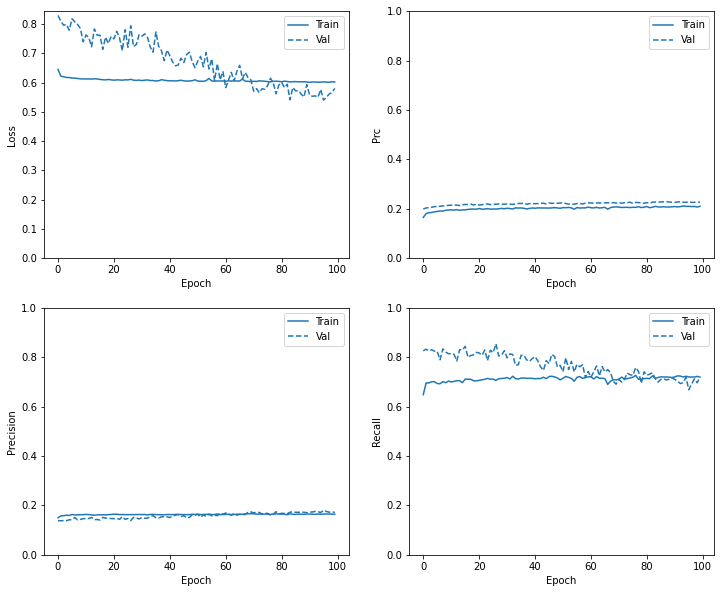

In [109]:
plot_metrics(weighted_history)
comet_exp.log_figure(figure=plt)

In [110]:
results = weighted_model.evaluate(val_ds)

for name, value in zip(weighted_model.metrics_names, results):
    print(name, ': ', value)
print()

485/485 [==============================] - 2s 4ms/step - loss: 0.5803 - tp: 15957.0000 - fp: 77472.0000 - tn: 148586.0000 - fn: 6261.0000 - accuracy: 0.6627 - precision: 0.1708 - recall: 0.7182 - auc: 0.7521 - prc: 0.2273
loss :  0.580315351486206
tp :  15957.0
fp :  77472.0
tn :  148586.0
fn :  6261.0
accuracy :  0.6627422571182251
precision :  0.17079278826713562
recall :  0.7182014584541321
auc :  0.752054750919342
prc :  0.22728924453258514



In [111]:
y_proba_val = weighted_model.predict(val_ds, verbose=1)

485/485 [==============================] - 2s 3ms/step


In [112]:
y_proba_val = np.concatenate([y for y in y_proba_val], axis=0)
y_proba_val

array([0.40867466, 0.8225095 , 0.01696908, ..., 0.7858704 , 0.04583094,
       0.68595225], dtype=float32)

In [113]:
threshold = 0.5
y_pred_val = np.where(y_proba_val > threshold, 1,0)

In [114]:
y_pred_val.sum()

93429

In [115]:
val_y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [116]:
val_y_true.sum()

22218

# Prepare for Comet Logs

In [117]:
#these will all get logged
params={'batch_size':BATCH_SIZE,
        'epochs':EPOCHS,
        'layer_num':4,
        'optimizer':'adam',
        'learning_rate':LEARNING_RATE
}

In [75]:
#will log metrics with the prefix 'test_'
# with experiment.test():
#     results = model.evaluate(x_test, y_test)
    
#     experiment.log_metrics(metrics)

In [76]:
# results = weighted_model.evaluate(test_ds)
# for name, value in zip(weighted_model.metrics_names, results):
#     print(name, ': ', value)

In [118]:
comet_exp.log_parameters(params)

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Neural-Net-with-FE2"
predscore_val_dict={}

In [ ]:
# import joblib

# predscore_val_dict[experiment]={}
# predscore_val_dict[experiment]['true_valid_label']=y_valid
# predscore_val_dict[experiment]['proba']=y_proba_val
# predscore_val_dict[experiment]['prediction']=y_pred_val

# ## Dumping model
# filename=f"{weights_dir}/{experiment}.pkl"
# filename
# joblib.dump(model,filename)

In [120]:
comet_exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/50331850708a45f7a6a22f8c7b8d2ac3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [243]             : (0.5663697123527527, 0.6879883408546448)
COMET INFO:     train_auc [243]                  : (0.6751080751419067, 0.7392146587371826)
COMET INFO:     train_batch_accuracy [11907]     : (0.4986454248428345, 0.90234375)
COMET INFO:     train_batch_auc [11907]          : (0.48664534091949463, 0.7892628312110901)
COMET INFO:     train_batch_fn [11907]           : (6.0, 10816.0)
COMET INFO:     train_batch_fp [11907]           : (8.0, 203762.0)
COMET INFO:     train_batch_loss [11907]         : (0.5408026576042175, 1.3990635871887207)
COMET INFO:     train_batch_prc [11907]          : (0.08611840009689331, 0.3

AttributeError: 'CPULoggingThread' object has no attribute 'isAlive'

## Plotting

              precision    recall  f1-score   support

           0       0.96      0.66      0.78    226058
           1       0.17      0.72      0.28     22218

    accuracy                           0.66    248276
   macro avg       0.57      0.69      0.53    248276
weighted avg       0.89      0.66      0.74    248276



{'web': 'https://www.comet.ml/api/image/download?imageId=b58d216f2c3b46b3a87d6f0a574d16c7&experimentKey=50331850708a45f7a6a22f8c7b8d2ac3',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=b58d216f2c3b46b3a87d6f0a574d16c7&experimentKey=50331850708a45f7a6a22f8c7b8d2ac3',
 'imageId': 'b58d216f2c3b46b3a87d6f0a574d16c7'}

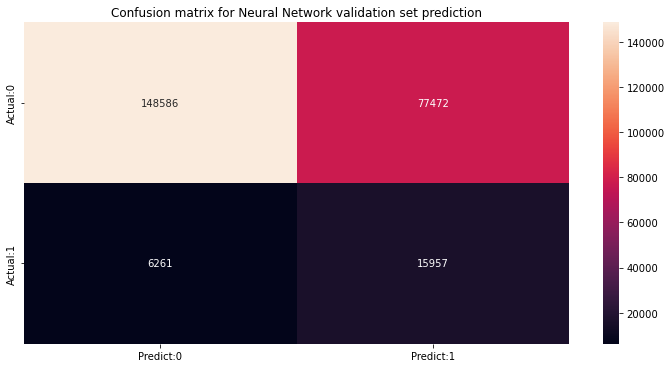

In [119]:
from ift6758.metrics import plot_metrics
img_path = os.path.join(tempfile.mkdtemp(), 'imgs')

plot_metrics.plotConfusion(val_y_true,y_pred_val, title='Confusion matrix for Neural Network validation set prediction')
comet_exp.log_figure(figure=plt)

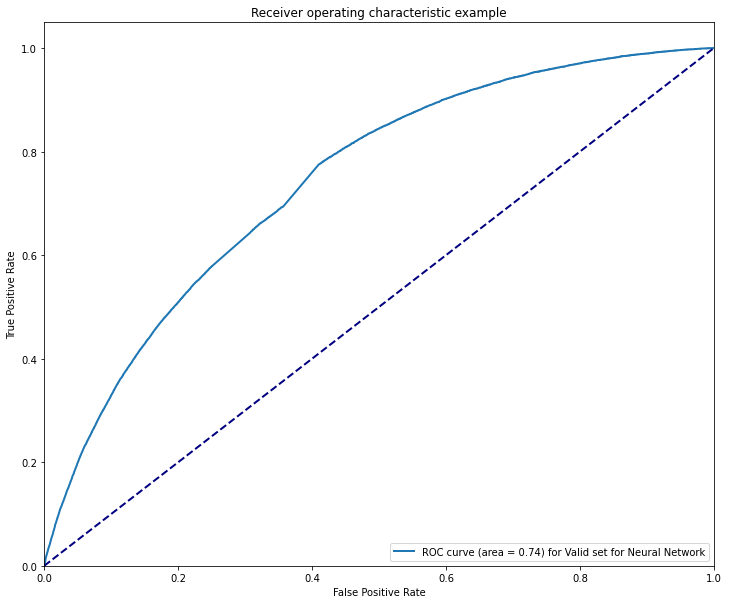

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 864x720 with 0 Axes>

In [87]:
plot_metrics.plot_roc([val_y_true],[y_proba_val],["Valid set for Neural Network"])
comet_exp.log_figure(figure=plt)

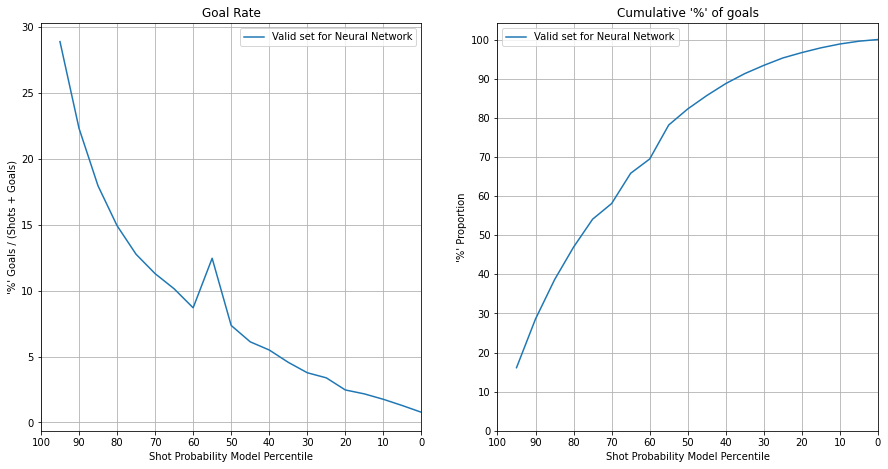

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 864x720 with 0 Axes>

In [88]:
plot_metrics.plot_percentile([val_y_true],[y_proba_val],bin_width=5,plot_labels=["Valid set for Neural Network"])
comet_exp.log_figure(figure=plt)

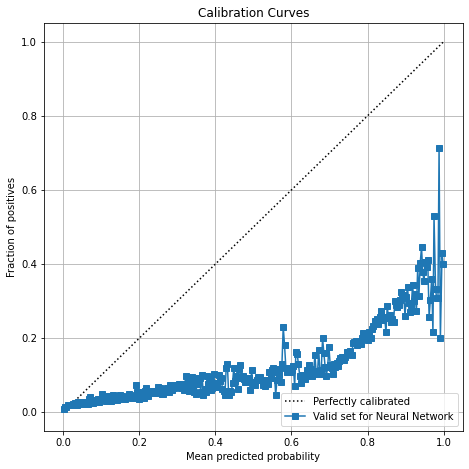

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 864x720 with 0 Axes>

In [89]:
plot_metrics.plot_calibration([val_y_true],[y_proba_val],plot_labels=["Valid set for Neural Network"])
comet_exp.log_figure(figure=plt)